[Normality] Female: KS=0.1484, p=0.8232 → Is normal? Yes


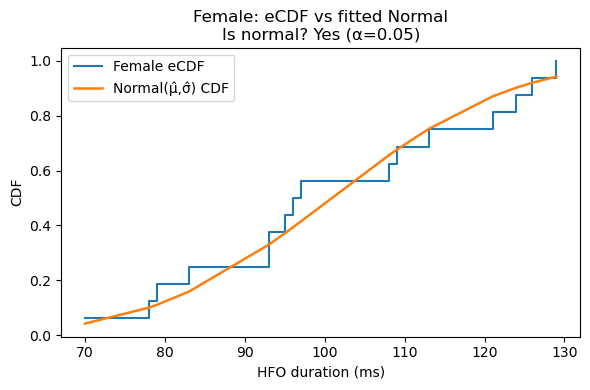

[Normality] Male: KS=0.1394, p=0.9137 → Is normal? Yes


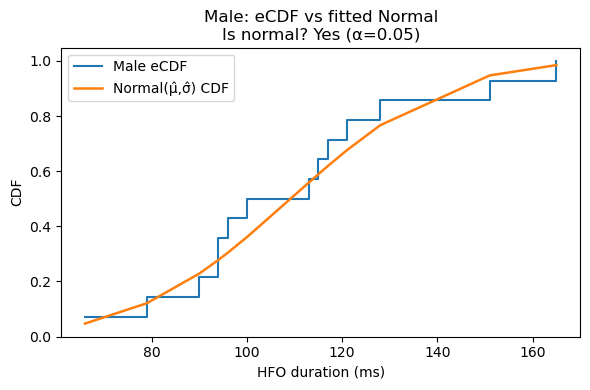

[MLE] Female: μ̂=100.88, σ̂=17.85
[MLE] Male  : μ̂=109.21, σ̂=25.82
[Two-sample KS] statistic=0.1875, p=0.8965


/opt/anaconda3/envs/mbta_env/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


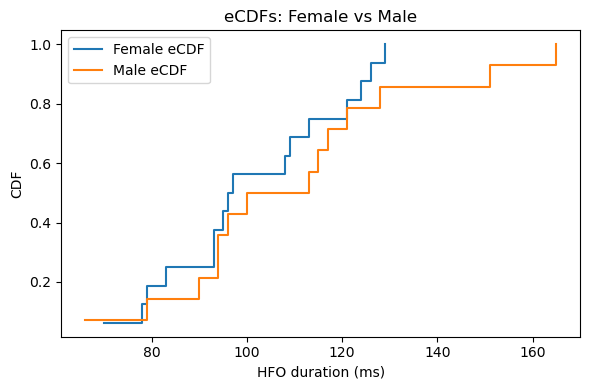

[Bootstrap] Mean diff (F−M) = -8.34 ms | 95% CI [-24.49, 7.35], p≈0.5106


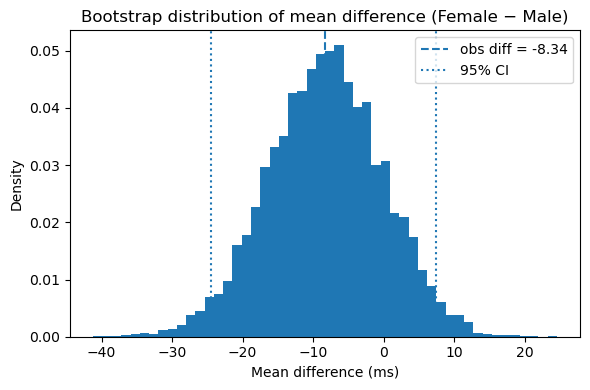

In [3]:
#!/usr/bin/env python3
"""
HFO duration demo: simulation, MLE, KS tests, bootstrap CI.
Author: <your-name>
---------------------------------------------------------------------
* Female: 80–120 ms,  μ≈100, σ≈8
* Male  : 60–160 ms,  μ≈110, σ≈20
---------------------------------------------------------------------
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, ks_2samp, kstest, norm
from scipy.optimize import minimize

# ---------------- 1) helper functions ------------------------------------
def simulate_truncnorm(low, high, mu, sigma, n, rng):
    """Simulate n samples from a truncated Normal on [low, high]."""
    a, b = (low - mu) / sigma, (high - mu) / sigma
    return truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n, random_state=rng)

def nll_truncnorm(params, x, low, high):
    """Negative log-likelihood for truncated Normal with fixed bounds."""
    mu, log_sigma = params
    sigma = np.exp(log_sigma)          # enforce σ>0
    a, b = (low - mu) / sigma, (high - mu) / sigma
    return -truncnorm.logpdf(x, a, b, loc=mu, scale=sigma).sum()

def mle_truncnorm(x, low, high):
    """MLEs (μ̂, σ̂) for truncated Normal via SciPy minimize."""
    mu0, sigma0 = x.mean(), x.std(ddof=0)
    out = minimize(
        nll_truncnorm, (mu0, np.log(sigma0)),
        args=(x, low, high),
        bounds=[(None, None), (np.log(1e-6), None)],
        method="L-BFGS-B"
    )
    mu_hat, sigma_hat = out.x[0], np.exp(out.x[1])
    return float(mu_hat), float(sigma_hat)

def ecdf(samples):
    xs = np.sort(samples)
    ys = np.arange(1, len(xs) + 1) / len(xs)
    return xs, ys

def bootstrap_mean_diff(x, y, B=10_000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    diff_hat = x.mean() - y.mean()
    bx = rng.choice(x, (B, len(x))).mean(axis=1)
    by = rng.choice(y, (B, len(y))).mean(axis=1)
    bdiff = bx - by
    ci_lo, ci_hi = np.percentile(bdiff, [2.5, 97.5])
    p_two = (np.abs(bdiff) >= abs(diff_hat)).mean()
    return diff_hat, ci_lo, ci_hi, p_two, bdiff

# ---------------- 2) simulate data ---------------------------------------
rng = np.random.default_rng(42)

# female parameters
f_low, f_high, f_mu_true, f_sigma_true, n_f = 80, 120, 100, 8, 300
# male parameters
m_low, m_high, m_mu_true, m_sigma_true, n_m = 60, 160, 110, 20, 300

# female = simulate_truncnorm(f_low, f_high, f_mu_true, f_sigma_true, n_f, rng)
# male   = simulate_truncnorm(m_low, m_high, m_mu_true, m_sigma_true, n_m, rng)
import pandas as pd

# Load real participant data
df = pd.read_csv("participants.csv")

# Clean/standardize sex column if necessary

# Split by sex
female = df[df['sex'] == 'f']['HFODuration'].dropna().values
male = df[df['sex'] == 'm']['HFODuration'].dropna().values

# ---------------- 3) normality KS test (per group) ------------------------
alpha = 0.05  # decision threshold

def ks_normality_test(x, label):
    mu, sigma = x.mean(), x.std(ddof=0)
    ks_stat, p_val = kstest(x, 'norm', args=(mu, sigma))
    is_normal = p_val >= alpha
    print(f"[Normality] {label}: KS={ks_stat:.4f}, p={p_val:.4g} "
          f"→ Is normal? {'Yes' if is_normal else 'No'}")
    # plot eCDF vs fitted Normal CDF
    xs, ys = ecdf(x)
    plt.figure(figsize=(6,4))
    plt.step(xs, ys, where='post', label=f"{label} eCDF")
    plt.plot(xs, norm.cdf(xs, loc=mu, scale=sigma),
             lw=1.8, label=f"Normal(μ̂,σ̂) CDF")
    plt.title(f"{label}: eCDF vs fitted Normal\nIs normal? "
              f"{'Yes' if is_normal else 'No'} (α={alpha})")
    plt.xlabel("HFO duration (ms)"); plt.ylabel("CDF"); plt.legend(); plt.tight_layout()
    plt.show()

ks_normality_test(female, "Female")
ks_normality_test(male,   "Male")

# ---------------- 4) MLE fit for truncated Normal ------------------------
muF_hat, sigF_hat = mle_truncnorm(female, f_low, f_high)
muM_hat, sigM_hat = mle_truncnorm(male,   m_low, m_high)

print(f"[MLE] Female: μ̂={muF_hat:.2f}, σ̂={sigF_hat:.2f}")
print(f"[MLE] Male  : μ̂={muM_hat:.2f}, σ̂={sigM_hat:.2f}")

# ---------------- 5) two-sample KS test (F vs M) --------------------------
ks_stat, ks_p = ks_2samp(female, male)
print(f"[Two-sample KS] statistic={ks_stat:.4f}, p={ks_p:.4g}")

# eCDF overlay for both groups
xf, yf = ecdf(female)
xm, ym = ecdf(male)
plt.figure(figsize=(6,4))
plt.step(xf, yf, where="post", label="Female eCDF")
plt.step(xm, ym, where="post", label="Male eCDF")
plt.title("eCDFs: Female vs Male")
plt.xlabel("HFO duration (ms)"); plt.ylabel("CDF"); plt.legend(); plt.tight_layout()
plt.show()

# ---------------- 6) bootstrap mean difference ---------------------------
diff_hat, ci_lo, ci_hi, p_boot, bdiff = bootstrap_mean_diff(female, male, rng=rng)
print(f"[Bootstrap] Mean diff (F−M) = {diff_hat:.2f} ms "
      f"| 95% CI [{ci_lo:.2f}, {ci_hi:.2f}], p≈{p_boot:.4f}")

plt.figure(figsize=(6,4))
plt.hist(bdiff, bins=50, density=True)
plt.axvline(diff_hat, ls='--', label=f"obs diff = {diff_hat:.2f}")
plt.axvline(ci_lo, ls=':', label="95% CI")
plt.axvline(ci_hi, ls=':')
plt.title("Bootstrap distribution of mean difference (Female − Male)")
plt.xlabel("Mean difference (ms)"); plt.ylabel("Density"); plt.legend(); plt.tight_layout()
plt.show()
